## Here is a notebook for importing the measurement data and plotting the errors

First, import the data from the CSV file and create an integer array from it.

In [1]:
import csv
import numpy as np

with open("Measurements.csv") as csvfile:
    csv_reader = csv.reader(csvfile, csv.QUOTE_MINIMAL, delimiter=",")
    next(csv_reader)  # skip the header row
    rows = []
    for row in csv_reader:
        rows.append(row)
    
data = np.asarray(rows, dtype=np.int)
print(data)

[[-1651 -1230  2111 ...   421    11    11]
 [-1890 -1230  2586 ...   660   486   486]
 [-1666 -1230  2122 ...   436    22    22]
 ...
 [ 1769  1230  2761 ...   539  -239   239]
 [ 1747  1230  2761 ...   517  -239   239]
 [ 1751  1230  2761 ...   521  -239   239]]


Now that we have all the data, we only need specific rows for each confidence ellipse.
We have five possible X true values: -1230, -650, 0, 650, 1230.
So let's write a function that takes one of the values as an input and outputs all the corresponding X and Z errors.

In [2]:
def get_x_and_z_errors(data, x_true_min, x_true_max=None):
    output = []
    if x_true_max == None:
        x_true_max = x_true_min
    filtered_array = data[np.where(np.logical_and(data[:, 1] <= x_true_max, data[:, 1] >= x_true_min))]
    
    return filtered_array[:, 4:7:2], sorted(set(filtered_array[:, 3]))

x_value = 0
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value)

Functions for plotting the confidence ellipse.
All of the code copied from and based on: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [4]:
def plot_errors(x_and_z_errors, x_value, z_values):
    x = x_and_z_errors[:, 0]
    y = x_and_z_errors[:, 1]

    fig, ax_nstd = plt.subplots(figsize=(5, 5))

    ax_nstd.scatter(x, y, s=2)

    confidence_ellipse(x, y, ax_nstd, n_std=1,
                       label=r'$1\sigma$', edgecolor='firebrick')
    confidence_ellipse(x, y, ax_nstd, n_std=2,
                       label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
    confidence_ellipse(x, y, ax_nstd, n_std=3,
                       label=r'$3\sigma$', edgecolor='blue', linestyle=':')

    plt.xlabel("X error (mm)")
    plt.ylabel("Z error (mm)")

    ax_nstd.set_title("X error vs. Z error, \nwhile X = " + str(x_value) + " (mm) and Z " + r"$\in$" + str(z_values) + " (mm)")
    ax_nstd.legend()
    plt.show()

## The following are the produced plots:

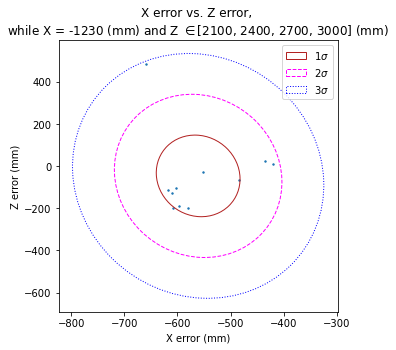

In [6]:
x_value = -1230
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value)

plot_errors(x_and_z_errors, x_value, z_values)

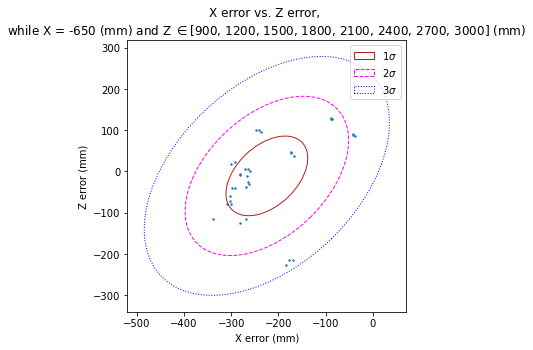

In [7]:
x_value = -650
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value)

plot_errors(x_and_z_errors, x_value, z_values)

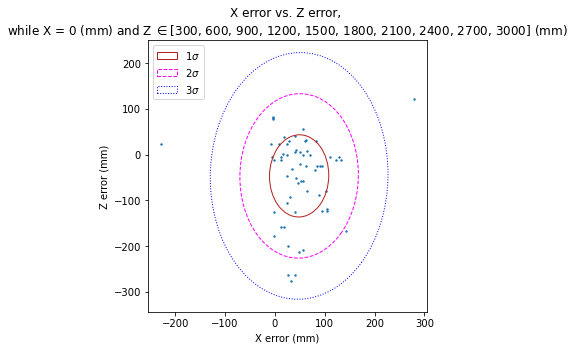

In [8]:
x_value = 0
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value)

plot_errors(x_and_z_errors, x_value, z_values)

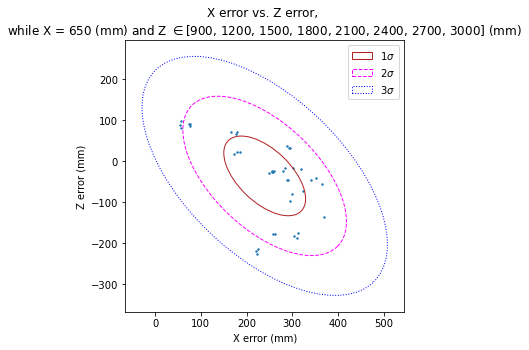

In [9]:
x_value = 650
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value)

plot_errors(x_and_z_errors, x_value, z_values)

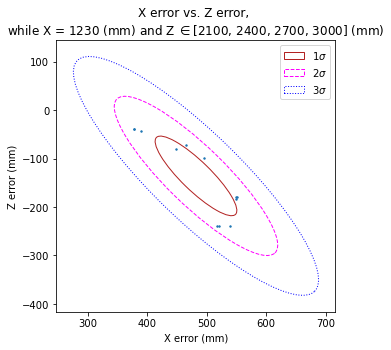

In [10]:
x_value = 1230
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value)

plot_errors(x_and_z_errors, x_value, z_values)

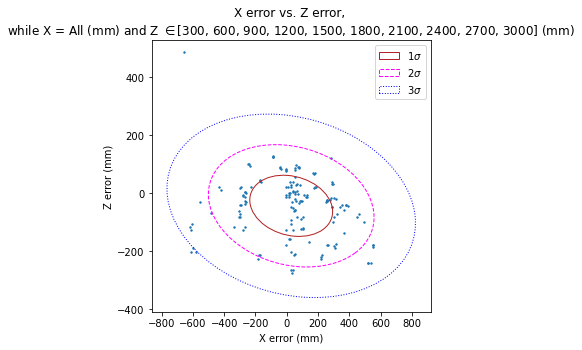

In [52]:
x_and_z_errors, z_values = get_x_and_z_errors(data, -1230, 1230)

plot_errors(x_and_z_errors, "All", z_values)

In [12]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']
x = x_and_z_errors[:, 0]
y = x_and_z_errors[:, 1]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    # estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
    #                                for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(x_and_z_errors)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        plt.scatter(x, y, marker='x', color=color)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

Automatically created module for IPython interactive environment


NameError: name 'n_classes' is not defined

(100, 2) (162, 2)
(162, 2)


TypeError: only integer scalar arrays can be converted to a scalar index

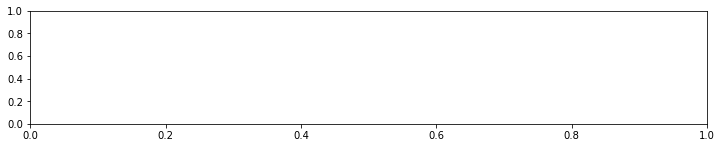

In [40]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        print(np.shape(X))
        plt.scatter(X[:, 0], X[Y:, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

    
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))

print(np.shape(X), np.shape(x_and_z_errors))

X = x_and_z_errors

plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full',
                              max_iter=100).fit(X)


# make_ellipses(gmm, plt.subplot(5, 1, 5))

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')

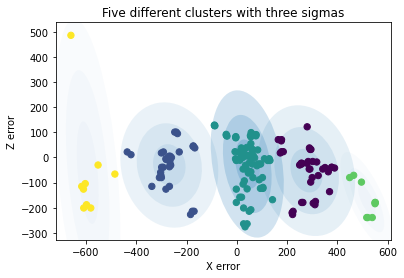

In [85]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    #ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, ax, label=True):
    #ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax, alpha=w * w_factor)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("X error")
ax.set_ylabel("Z error")
ax.set_title("Five different clusters with three sigmas")
        
gmm = GaussianMixture(n_components=5)
plot_gmm(gmm, x_and_z_errors, ax)
plt.show()